<a href="https://colab.research.google.com/github/LNBeyak/Branching/blob/main/DS_QQFF2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## Code for Setup -> Upload -> Excel Summaries -> Null/zero handling -> Classical SVM -> Quantum-kernel SVM w/ Qiskit
# Presented by Lindsay Beyak

# 1) Install required packages (run once per new Colab session)
!pip install --quiet pandas openpyxl scikit-learn matplotlib qiskit qiskit-machine-learning



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 11.5 MB/s eta 0:00:00


In [3]:
# 2) Imports & basic display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)


In [4]:
# 3) Upload your Excel file (select QFF_health.xlsm when prompted)
uploaded = files.upload()  # Choose QFF_health.xlsm

# Ensure the expected filename exists (adjust if needed)
excel_filename = "QFF_health.xlsm"
if excel_filename not in uploaded:
    # If you uploaded with a different name, auto-pick the first uploaded file
    excel_filename = list(uploaded.keys())[0]
    print(f"Using uploaded file: {excel_filename}")
else:
    print(f"Using uploaded file: {excel_filename}")


Saving QFF_health.xlsm to QFF_health.xlsm
Using uploaded file: QFF_health.xlsm


In [5]:
# 4) Review Data for Cleanliness
df = pd.read_excel("QFF_health.xlsm")

# Make a copy so you preserve the original
df_dirty = df.copy()

# Set random seed for reproducibility
np.random.seed(42)

# Percentage of entries to replace with NaN
missing_fraction = 0.05  # 5% of all cells

# Get total number of values
n_total = df_dirty.size
n_missing = int(n_total * missing_fraction)

# Randomly choose positions to make NaN
for _ in range(n_missing):
    # Randomly pick a row and column
    i = np.random.randint(0, df_dirty.shape[0])
    j = np.random.randint(0, df_dirty.shape[1])
    df_dirty.iat[i, j] = np.nan

print(f"Inserted {n_missing} random NaNs ({missing_fraction*100:.1f}% of data).")
df_dirty.head()


Inserted 54000 random NaNs (5.0% of data).


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Physical exercise,Carbs,Proteins,Fats,Calories,meal_name,meal_type,diet_type,sugar_g,sodium_mg,cholesterol_mg,serving_size_g,cooking_method,prep_time_min,cook_time_min,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,BMI_calc,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc,Burns_Calories_Bin
0,34.91,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,26.800377,1.50,3.99,2.01,24.87,2.99,0.01,267.68,106.05,71.63,1806.0,Other,Lunch,NaN,31.77,1729.94,285.05,120.47,Grilled,16.24,NaN,1.31,Decline Push-ups,4.99,20.91,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,Advanced,Legs,Lats,Dumbbell flyes,24.870447,2139.59,0.500432,1.624789,0.741237,0.835985,725.10,47.777394,685.1600,7.260425e+19,Medium
1,23.37,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,27.655021,1.90,4.00,2.01,NaN,3.01,0.97,214.32,85.41,56.97,1577.0,Other,Lunch,Vegetarian,12.34,693.08,300.61,109.15,NaN,16.47,12.01,1.92,Bear Crawls,4.01,16.15,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,Intermediate,Chest,Lats,Lateral raises,23.479709,1711.65,NaN,1.514093,0.551247,0.734270,-232.91,40.809803,978.6184,1.020506e+20,High
2,33.20,Female,NaN,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,24.320821,1.88,2.99,1.02,21.15,1.99,-0.02,246.04,98.11,65.48,1608.0,Other,Breakfast,Paleo,42.81,2142.48,215.42,399.43,Boiled,NaN,6.09,4.70,Dips,5.00,21.90,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,Intermediate,Arms,Grip Strength,Standing calf raises,21.148123,1965.92,0.500610,1.663445,0.574534,0.708124,805.74,44.635580,654.5266,1.079607e+20,High
3,NaN,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,32.813572,2.50,3.99,1.99,32.45,3.00,0.04,203.22,80.84,54.56,NaN,Other,Lunch,Paleo,9.34,123.20,9.70,314.31,Fried,27.73,103.72,4.85,Mountain Climbers,4.01,16.92,Improves coordination and cardiovascular health,351.65,"Biceps, Forearms",Parallel Bars or Chair,Advanced,Shoulders,Upper,Incline dumbbell flyes,32.449827,NaN,0.499533,0.862017,0.744155,0.811150,1206.21,63.007432,773.6300,8.987921e+19,NaN
4,45.09,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,17.307319,2.91,4.00,2.00,14.83,NaN,3.00,332.79,133.05,88.43,1470.0,Other,Breakfast,Vegan,23.78,1935.11,116.89,99.22,Baked,34.16,46.55,3.07,Bicep Curls,4.99,15.01,Targets obliques and improves core rotation,329.36,"Chest, Triceps",Wall,Advanced,Abs,Wrist Flexors,Military press,14.831372,2659.23,0.500581,2.538153,0.668405,0.789751,NaN,43.347504,711.4176,5.264685e+19,NaN


In [6]:
# Compare Clean Dataset versus Unclean Dataset
print("Before cleaning (unclean data sample):")
display(df_dirty.head(10))

print("\nAfter cleaning (using our cleaning code):")
df_cleaned = df_dirty.copy()

# Cleaning code (from your earlier cells)
for c in df_cleaned.select_dtypes(include=[np.number]).columns:
    df_cleaned[c].fillna(df_cleaned[c].mean(), inplace=True)
for c in df_cleaned.select_dtypes(exclude=[np.number]).columns:
    df_cleaned[c].fillna(df_cleaned[c].mode().iloc[0], inplace=True)

display(df_cleaned.head(10))


Before cleaning (unclean data sample):


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Physical exercise,Carbs,Proteins,Fats,Calories,meal_name,meal_type,diet_type,sugar_g,sodium_mg,cholesterol_mg,serving_size_g,cooking_method,prep_time_min,cook_time_min,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,BMI_calc,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc,Burns_Calories_Bin
0,34.91,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,26.800377,1.50,3.99,2.01,24.87,2.99,0.01,267.68,106.05,71.63,1806.0,Other,Lunch,NaN,31.77,1729.94,285.05,120.47,Grilled,16.24,NaN,1.31,Decline Push-ups,4.99,20.91,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,Advanced,Legs,Lats,Dumbbell flyes,24.870447,2139.59,0.500432,1.624789,0.741237,0.835985,725.10,47.777394,685.1600,7.260425e+19,Medium
1,23.37,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,27.655021,1.90,4.00,2.01,NaN,3.01,0.97,214.32,85.41,56.97,1577.0,Other,Lunch,Vegetarian,12.34,693.08,300.61,109.15,NaN,16.47,12.01,1.92,Bear Crawls,4.01,16.15,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,Intermediate,Chest,Lats,Lateral raises,23.479709,1711.65,NaN,1.514093,0.551247,0.734270,-232.91,40.809803,978.6184,1.020506e+20,High
2,33.20,Female,NaN,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,24.320821,1.88,2.99,1.02,21.15,1.99,-0.02,246.04,98.11,65.48,1608.0,Other,Breakfast,Paleo,42.81,2142.48,215.42,399.43,Boiled,NaN,6.09,4.70,Dips,5.00,21.90,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,Intermediate,Arms,Grip Strength,Standing calf raises,21.148123,1965.92,0.500610,1.663445,0.574534,0.708124,805.74,44.635580,654.5266,1.079607e+20,High
3,NaN,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,32.813572,2.50,3.99,1.99,32.45,3.00,0.04,203.22,80.84,54.56,NaN,Other,Lunch,Paleo,9.34,123.20,9.70,314.31,Fried,27.73,103.72,4.85,Mountain Climbers,4.01,16.92,Improves coordination and cardiovascular health,351.65,"Biceps, Forearms",Parallel Bars or Chair,Advanced,Shoulders,Upper,Incline dumbbell flyes,32.449827,NaN,0.499533,0.862017,0.744155,0.811150,1206.21,63.007432,773.6300,8.987921e+19,NaN
4,45.09,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,17.307319,2.91,4.00,2.00,14.83,NaN,3.00,332.79,133.05,88.43,1470.0,Other,Breakfast,Vegan,23.78,1935.11,116.89,99.22,Baked,34.16,46.55,3.07,Bicep Curls,4.99,15.01,Targets obliques and improves core rotation,329.36,"Chest, Triceps",Wall,Advanced,Abs,Wrist Flexors,Military press,14.831372,2659.23,0.500581,2.538153,0.668405,0.789751,NaN,43.347504,711.4176,5.264685e+19,NaN
5,53.19,Female,105.05,1.84,176.52,130.60,61.84,0.69,453.33,Yoga,32.049064,2.91,3.02,1.00,31.03,2.99,-0.04,170.86,67.92,46.06,2767.0,Other,Snack,Keto,15.89,2382.39,NaN,416.54,Steamed,20.98,54.64,3.38,Leg Press,4.00,25.10,Builds explosive power,374.56,"Core, Obliques",Resistance Band or Cable Machine,Beginner,NaN,Wrist Flexors,Skull crushers,31.028474,1369.66,0.498985,0.646549,0.599581,0.739860,2313.67,71.382458,516.8928,1.505159e+20,Very High
6,23.17,Male,58.41,1.78,184.75,140.90,58.01,1.67,1953.90,Strength,NaN,2.71,4.96,NaN,18.44,2.02,-0.03,280.33,112.35,74.97,1867.0,Other,Breakfast,Low-Carb,12.48,2220.46,56.69,289.93,Fried,52.43,46.08,3.81,Thrusters,5.01,25.04,Strengthens back and improves posture,328.94,Core,None or Dumbbells,Advanced,Shoulders,Wrist Flexors,Barbell rows,18.435172,2245.45,0.499374,1.923472,0.654016,0.762652,-86.90,46.408911,1098.6596,5.210106e+19,Low
7,55.92,Female,84.07,1.63,183.87,141.12,51.79,1.01,727.81,Yoga,32.088176,2.88,3.97,2.01,31.64,2.99,0.00,262.57,105.41,70.37,2191.0,Other,Snack,Low-Carb,2.87,1501.99,74.70,487.67,Raw,38.57,36.64,3.16,Turkish Get-ups,4.9


After cleaning (using our cleaning code):


/tmp/ipython-input-629666691.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[c].fillna(df_cleaned[c].mean(), inplace=True)
/tmp/ipython-input-629666691.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Physical exercise,Carbs,Proteins,Fats,Calories,meal_name,meal_type,diet_type,sugar_g,sodium_mg,cholesterol_mg,serving_size_g,cooking_method,prep_time_min,cook_time_min,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,BMI_calc,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc,Burns_Calories_Bin
0,34.910000,Male,65.270000,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,26.800377,1.50,3.99,2.010000,24.870000,2.990000,0.01,267.68,106.05,71.63,1806.000000,Other,Lunch,Low-Carb,31.77,1729.94,285.05000,120.47,Grilled,16.240000,61.500273,1.31,Decline Push-ups,4.99,20.91,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,Advanced,Legs,Lats,Dumbbell flyes,24.870447,2139.590000,0.500432,1.624789,0.741237,0.835985,725.100000,47.777394,685.160000,7.260425e+19,Medium
1,23.370000,Female,56.410000,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,27.655021,1.90,4.00,2.010000,24.925927,3.010000,0.97,214.32,85.41,56.97,1577.000000,Other,Lunch,Vegetarian,12.34,693.08,300.61000,109.15,Baked,16.470000,12.010000,1.92,Bear Crawls,4.01,16.15,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,Intermediate,Chest,Lats,Lateral raises,23.479709,1711.650000,0.499986,1.514093,0.551247,0.734270,-232.910000,40.809803,978.618400,1.020506e+20,High
2,33.200000,Female,73.921061,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,24.320821,1.88,2.99,1.020000,21.150000,1.990000,-0.02,246.04,98.11,65.48,1608.000000,Other,Breakfast,Paleo,42.81,2142.48,215.42000,399.43,Boiled,33.539328,6.090000,4.70,Dips,5.00,21.90,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,Intermediate,Arms,Grip Strength,Standing calf raises,21.148123,1965.920000,0.500610,1.663445,0.574534,0.708124,805.740000,44.635580,654.526600,1.079607e+20,High
3,38.855763,Female,93.780000,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,32.813572,2.50,3.99,1.990000,32.450000,3.000000,0.04,203.22,80.84,54.56,2024.114647,Other,Lunch,Paleo,9.34,123.20,9.70000,314.31,Fried,27.730000,103.720000,4.85,Mountain Climbers,4.01,16.92,Improves coordination and cardiovascular health,351.65,"Biceps, Forearms",Parallel Bars or Chair,Advanced,Shoulders,Upper,Incline dumbbell flyes,32.449827,1998.418252,0.499533,0.862017,0.744155,0.811150,1206.210000,63.007432,773.630000,8.987921e+19,High
4,45.090000,Male,52.420000,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,17.307319,2.91,4.00,2.000000,14.830000,2.864968,3.00,332.79,133.05,88.43,1470.000000,Other,Breakfast,Vegan,23.78,1935.11,116.89000,99.22,Baked,34.160000,46.550000,3.07,Bicep Curls,4.99,15.01,Targets obliques and improves core rotation,329.36,"Chest, Triceps",Wall,Advanced,Abs,Wrist Flexors,Military press,14.831372,2659.230000,0.500581,2.538153,0.668405,0.789751,744.997387,43.347504,711.417600,5.264685e+19,High
5,53.190000,Female,105.050000,1.84,176.52,130.60,61.84,0.69,453.33,Yoga,32.049064,2.91,3.02,1.000000,31.030000,2.990000,-0.04,170.86,67.92,46.06,2767.000000,Other,Snack,Keto,15.89,2382.39,148.65844,416.54,Steamed,20.980000,54.640000,3.38,Leg Press,4.00,25.10,Builds explosive power,374.56,"Core, Obliques",Resistance Band or Cable Machine,Beginner,Legs,Wrist Flexors,Skull crushers,31.028474,1369.660000,0.498985,0.646549,0.599581,0.739860,2313.670000,71.382458,516.892800,1.505159e+20,Very High
6,23.170000,Male,58.410000,1.78,184.75,140.90,58.01,1.67,1953.90,Strength,26.101529,2.71,4.96,1.810147,18.440000,2.020000,-0.03,280.33,112.35,74.97,1867.000000,Other,Breakfast,Low-Carb,12.48,2220.46,56.69000,289.93,Fried,52.430000,46.080000,3.81,Thrusters,5.01,25.04,Strengthens back and improves posture,328.94,Core,None or Dumbbells,Adva

/tmp/ipython-input-854064433.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[c].fillna(df_cleaned[c].mean(), inplace=True)
/tmp/ipython-input-854064433.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

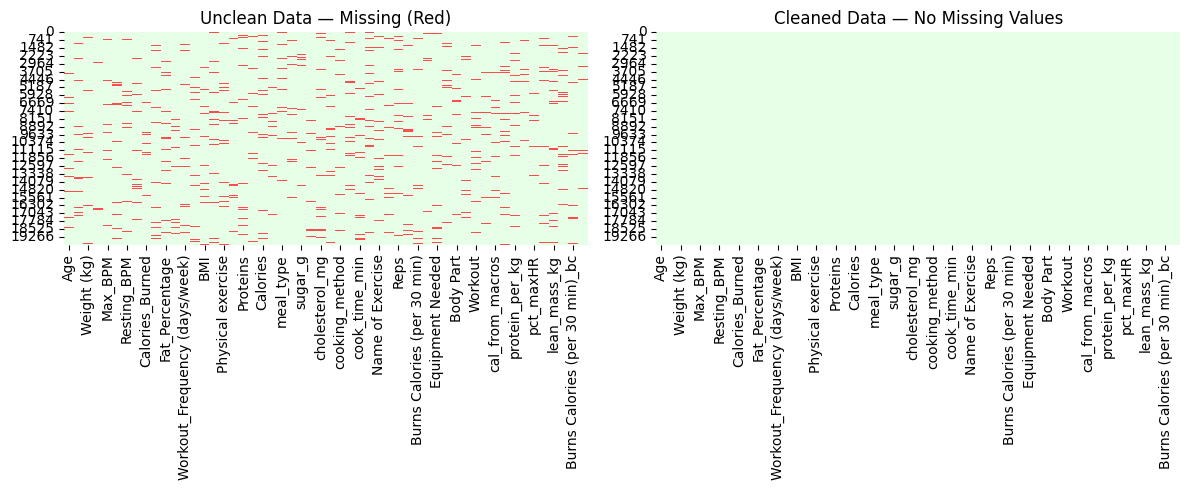

In [7]:
# Visualize missing vs cleaned data side-by-side
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First: create the "dirty" dataset with random NaNs if you haven't already
# (Assuming df_dirty exists from earlier code)

# Then: make a cleaned version
df_cleaned = df_dirty.copy()

# Simple cleaning (fill numeric NaNs with mean, categorical with mode)
for c in df_cleaned.select_dtypes(include=[np.number]).columns:
    df_cleaned[c].fillna(df_cleaned[c].mean(), inplace=True)

for c in df_cleaned.select_dtypes(exclude=[np.number]).columns:
    if df_cleaned[c].isna().any():
        df_cleaned[c].fillna(df_cleaned[c].mode().iloc[0], inplace=True)

# --- Create heatmaps to show where missing values exist ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(df_dirty.isnull(), cbar=False, cmap=["#e6ffe6", "#ff4d4d"])
plt.title("Unclean Data — Missing (Red)")

plt.subplot(1, 2, 2)
sns.heatmap(df_cleaned.isnull(), cbar=False, cmap=["#e6ffe6", "#ff4d4d"])
plt.title("Cleaned Data — No Missing Values")

plt.tight_layout()
plt.show()


In [8]:
# 5) Read the first sheet of the Excel macro-enabled workbook
# (openpyxl supports .xlsm as long as macros aren't needed)
df = pd.read_excel(excel_filename, sheet_name=0, engine="openpyxl")

print("Data preview:")
display(df.head())
print("\nInfo:")
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())


Data preview:


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Physical exercise,Carbs,Proteins,Fats,Calories,meal_name,meal_type,diet_type,sugar_g,sodium_mg,cholesterol_mg,serving_size_g,cooking_method,prep_time_min,cook_time_min,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,BMI_calc,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc,Burns_Calories_Bin
0,34.91,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,26.800377,1.50,3.99,2.01,24.87,2.99,0.01,267.68,106.05,71.63,1806,Other,Lunch,Vegan,31.77,1729.94,285.05,120.47,Grilled,16.24,110.79,1.31,Decline Push-ups,4.99,20.91,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,Advanced,Legs,Lats,Dumbbell flyes,24.870447,2139.59,0.500432,1.624789,0.741237,0.835985,725.10,47.777394,685.1600,7.260425e+19,Medium
1,23.37,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,27.655021,1.90,4.00,2.01,23.48,3.01,0.97,214.32,85.41,56.97,1577,Other,Lunch,Vegetarian,12.34,693.08,300.61,109.15,Fried,16.47,12.01,1.92,Bear Crawls,4.01,16.15,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,Intermediate,Chest,Lats,Lateral raises,23.479709,1711.65,0.500850,1.514093,0.551247,0.734270,-232.91,40.809803,978.6184,1.020506e+20,High
2,33.20,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,24.320821,1.88,2.99,1.02,21.15,1.99,-0.02,246.04,98.11,65.48,1608,Other,Breakfast,Paleo,42.81,2142.48,215.42,399.43,Boiled,54.35,6.09,4.70,Dips,5.00,21.90,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,Intermediate,Arms,Grip Strength,Standing calf raises,21.148123,1965.92,0.500610,1.663445,0.574534,0.708124,805.74,44.635580,654.5266,1.079607e+20,High
3,38.69,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,32.813572,2.50,3.99,1.99,32.45,3.00,0.04,203.22,80.84,54.56,2657,Other,Lunch,Paleo,9.34,123.20,9.70,314.31,Fried,27.73,103.72,4.85,Mountain Climbers,4.01,16.92,Improves coordination and cardiovascular health,351.65,"Biceps, Forearms",Parallel Bars or Chair,Advanced,Shoulders,Upper,Incline dumbbell flyes,32.449827,1627.28,0.499533,0.862017,0.744155,0.811150,1206.21,63.007432,773.6300,8.987921e+19,High
4,45.09,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,17.307319,2.91,4.00,2.00,14.83,3.00,3.00,332.79,133.05,88.43,1470,Other,Breakfast,Vegan,23.78,1935.11,116.89,99.22,Baked,34.16,46.55,3.07,Bicep Curls,4.99,15.01,Targets obliques and improves core rotation,329.36,"Chest, Triceps",Wall,Advanced,Abs,Wrist Flexors,Military press,14.831372,2659.23,0.500581,2.538153,0.668405,0.789751,303.60,43.347504,711.4176,5.264685e+19,Low



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             20000 non-null  float64
 1   Gender                          20000 non-null  object 
 2   Weight (kg)                     20000 non-null  float64
 3   Height (m)                      20000 non-null  float64
 4   Max_BPM                         20000 non-null  float64
 5   Avg_BPM                         20000 non-null  float64
 6   Resting_BPM                     20000 non-null  float64
 7   Session_Duration (hours)        20000 non-null  float64
 8   Calories_Burned                 20000 non-null  float64
 9   Workout_Type                    20000 non-null  object 
 10  Fat_Percentage                  20000 non-null  float64
 11  Water_Intake (liters)           20000 non-null  float64
 12  Workout_Frequency (days/w

In [9]:
# 6) Excel-like basics on a numeric column
# Pick a numeric column to demo (auto-pick the first numeric if you don't have a specific one)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if not num_cols:
    raise ValueError("No numeric columns found. Please ensure your sheet has numeric data.")
demo_col = num_cols[0]
print(f"Demo numeric column: {demo_col}")

print("— Excel-style summaries —")
print("Sum:", df[demo_col].sum(skipna=True))
print("Average (mean):", df[demo_col].mean(skipna=True))
print("Max:", df[demo_col].max(skipna=True))

# Clarify difference:
print("\nReminder:")
print("NaN = missing (ignored by mean/sum unless handled).")
print("0   = a real value and will affect mean/sum.")


Demo numeric column: Age
— Excel-style summaries —
Sum: 777029.07
Average (mean): 38.8514535
Max: 59.67

Reminder:
NaN = missing (ignored by mean/sum unless handled).
0   = a real value and will affect mean/sum.


In [10]:
# 7) Basic cleaning: handle nulls and empty strings

# Option A: Convert common "empty-like" strings to NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Fill numeric NaNs with column means
for c in df.select_dtypes(include=[np.number]).columns:
    if df[c].isna().any():
        df[c].fillna(df[c].mean(), inplace=True)

# Fill categorical NaNs with mode (most frequent)
for c in df.select_dtypes(exclude=[np.number]).columns:
    if df[c].isna().any():
        mode_val = df[c].mode(dropna=True)
        if not mode_val.empty:
            df[c].fillna(mode_val.iloc[0], inplace=True)
        else:
            df[c].fillna("Unknown", inplace=True)

print("Nulls after cleaning:")
print(df.isnull().sum())


Nulls after cleaning:
Age                               0
Gender                            0
Weight (kg)                       0
Height (m)                        0
Max_BPM                           0
Avg_BPM                           0
Resting_BPM                       0
Session_Duration (hours)          0
Calories_Burned                   0
Workout_Type                      0
Fat_Percentage                    0
Water_Intake (liters)             0
Workout_Frequency (days/week)     0
Experience_Level                  0
BMI                               0
Daily meals frequency             0
Physical exercise                 0
Carbs                             0
Proteins                          0
Fats                              0
Calories                          0
meal_name                         0
meal_type                         0
diet_type                         0
sugar_g                           0
sodium_mg                         0
cholesterol_mg                    0
servin

In [11]:
# 8) Quick data overview (like Excel's quick stats)
display(df.describe(include='all'))

# Simple numeric correlation preview
numeric_df = df.select_dtypes(include=[np.number])
if not numeric_df.empty:
    display(numeric_df.corr().round(2))


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Physical exercise,Carbs,Proteins,Fats,Calories,meal_name,meal_type,diet_type,sugar_g,sodium_mg,cholesterol_mg,serving_size_g,cooking_method,prep_time_min,cook_time_min,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,BMI_calc,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc,Burns_Calories_Bin
count,20000.000000,20000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000,20000,20000,20000.000000,20000.000000,20000.000000,20000.000000,20000,20000.000000,20000.000000,20000.000000,20000,20000.000000,20000.000000,20000,20000.000000,20000,20000,20000,20000,20000,20000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,20000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,6,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,55,NaN,NaN,49,NaN,36,20,3,7,13,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,NaN,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strength,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,Lunch,Paleo,NaN,NaN,NaN,NaN,Baked,NaN,NaN,NaN,Flutter Kicks,NaN,NaN,Full body workout,NaN,"Chest, Triceps",Step or Box,Intermediate,Abs,Upper,Leg press,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
freq,NaN,10028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000,5047,3403,NaN,NaN,NaN,NaN,2953,NaN,NaN,NaN,412,NaN,NaN,445,NaN,602,1049,6696,2897,1599,423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5003
mean,38.851453,NaN,73.898832,1.723093,179.889702,143.704306,62.195813,1.259446,1280.109600,NaN,26.101313,2.627485,3.318629,1.809176,24.921680,2.864804,0.452503,249.778592,99.91829,66.612172,2024.418300,NaN,NaN,NaN,24.531042,1258.139709,148.465602,302.719499,NaN,33.517447,61.502164,2.989303,NaN,4.425059,19.427316,NaN,344.046515,NaN,NaN,NaN,NaN,NaN,NaN,24.921651,1998.297076,0.499983,1.460142,0.699005,0.802305,744.308699,53.786384,866.352318,8.631802e+19,NaN
std,12.114580,NaN,21.173010,0.127033,11.510805,14.267688,7.289351,0.341336,502.228982,NaN,4.996160,0.604724,0.911198,0.736204,6.701126,0.636649,0.986628,55.108623,22.04367,14.699284,541.891521,NaN,NaN,NaN,14.446105,716.618987,87.382817,115.711949,NaN,16.526869,33.579746,1.157692,NaN,0.579596,3.679707,NaN,32.138782,NaN,NaN,NaN,NaN,NaN,NaN,6.701144,440.848408,0.001455,0.518946,0.144880,0.096613,720.946619,12.498740,250.317069,3.197579e+19,NaN
min,18.000000,NaN,39.180000,1.490000,159.310000,119.070000,49.490000,0.490000,323.110000,NaN,11.333134,1.460000,1.940000,1.000000,12.040000,1.950000,-0.070000,137.720000,55.17000,36.590000,781.000000,NaN,NaN,NaN,-0.670000,19.220000,-3.890000,95.950000,NaN,3.950000,3.350000,0.930000,NaN,2.960000,4.850000,NaN,128.750000,NaN,NaN,NaN,NaN,NaN,NaN,12.037907,1105.570000,0.492434,0.516706,0.371344,0.599789,-1266.220000,30.946261,219.852800,2.491905e+16,NaN
25%,28.170000,NaN,58.160000,1.620000,170.057500,131.220000,55.960000,1.050000,910.800000,NaN,22.387807,2.170000,2.980000,1.010000,20.097500,2.020000,-0.010000,207.547500,83.04000,55.340000,1634.000000,NaN,NaN,NaN,11.990000,645.127500,71.970000,207.217500,NaN,18.587500,32.477500,1.940000,NaN,4.000000,16.120000,NaN,337.600000,NaN,NaN,NaN,NaN,NaN,NaN,20.094975,1661.022500,0.499054,1.076294,0.583656,0.727676,261.432500,44.587037,714.098250,6.441978e+19,NaN
50%,39.865000,NaN,70.000000,1.710000,180.140000,142.990000,62.200000,1.270000,1231.450000,NaN,25.822504,2.610000,3.010000,1.990000,24.120000,3.

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Physical exercise,Carbs,Proteins,Fats,Calories,sugar_g,sodium_mg,cholesterol_mg,serving_size_g,prep_time_min,cook_time_min,rating,Sets,Reps,Burns Calories (per 30 min),BMI_calc,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc
Age,1.00,-0.04,-0.04,-0.03,0.04,0.01,-0.03,-0.02,-0.03,0.04,0.01,-0.02,-0.02,0.04,0.02,0.05,0.05,0.05,-0.04,0.01,0.04,0.01,0.01,-0.01,-0.01,-0.01,0.02,-0.03,0.01,-0.02,0.05,-0.01,0.07,0.04,0.05,-0.02,-0.05,-0.03,-0.02
Weight (kg),-0.04,1.00,0.35,0.07,0.02,-0.03,-0.00,-0.00,0.78,0.40,-0.00,0.02,0.86,0.04,-0.01,-0.00,-0.00,-0.00,0.98,-0.01,-0.01,0.02,0.04,-0.02,-0.04,-0.02,0.01,-0.03,0.09,0.86,-0.00,-0.00,-0.73,-0.02,-0.02,0.74,0.98,0.02,0.25
Height (m),-0.04,0.35,1.00,-0.01,-0.01,0.01,0.01,0.01,-0.16,0.40,0.01,0.02,-0.17,-0.01,0.01,0.01,0.01,0.01,0.35,-0.02,0.01,0.03,0.04,0.05,-0.02,0.02,-0.02,0.00,0.07,-0.17,0.01,0.01,-0.25,-0.01,-0.01,0.25,0.48,0.03,0.10
Max_BPM,-0.03,0.07,-0.01,1.00,-0.03,0.04,0.01,0.00,0.07,0.04,-0.04,-0.00,0.07,-0.02,-0.01,-0.01,-0.01,-0.01,0.06,0.05,0.02,-0.02,-0.04,0.00,-0.02,-0.06,-0.03,-0.04,-0.02,0.07,-0.01,-0.00,-0.06,-0.51,-0.56,0.04,0.06,0.00,-0.03
Avg_BPM,0.04,0.02,-0.01,-0.03,1.00,0.06,0.02,0.01,0.01,0.01,-0.02,-0.01,0.03,0.04,-0.03,0.03,0.03,0.03,0.01,-0.05,0.02,-0.01,0.02,0.00,-0.02,-0.02,-0.05,-0.03,-0.07,0.03,0.03,-0.01,0.02,0.86,0.84,0.01,0.01,-0.01,-0.06
Resting_BPM,0.01,-0.03,0.01,0.04,0.06,1.00,-0.02,-0.00,-0.04,0.01,-0.01,-0.00,-0.04,0.04,0.02,0.04,0.04,0.04,-0.03,0.03,0.05,-0.03,-0.00,-0.01,-0.03,-0.00,0.00,0.00,0.04,-0.04,0.04,-0.02,0.07,-0.09,0.03,-0.02,-0.03,-0.00,-0.00
Session_Duration (hours),-0.03,-0.00,0.01,0.01,0.02,-0.02,1.00,0.81,-0.03,0.29,0.64,0.76,-0.00,0.02,0.05,0.01,0.01,0.01,0.05,-0.01,-0.01,0.09,0.05,-0.00,-0.06,0.02,0.01,0.03,-0.01,-0.00,0.01,0.01,-0.04,0.02,0.01,-0.53,0.03,0.94,-0.03
Calories_Burned,-0.02,-0.00,0.01,0.00,0.01,-0.00,0.81,1.00,-0.03,0.26,0.58,0.70,-0.00,0.03,0.05,0.01,0.01,0.01,0.05,-0.00,-0.01,0.07,0.03,-0.00,-0.06,0.03,0.02,0.04,0.01,-0.00,0.01,0.01,-0.04,0.01,0.01,-0.66,0.02,0.77,-0.01
Fat_Percentage,-0.03,0.78,-0.16,0.07,0.01,-0.04,-0.03,-0.03,1.00,0.19,-0.04,-0.03,0.90,0.05,-0.01,-0.01,-0.01,-0.01,0.76,-0.00,-0.02,0.00,0.02,-0.04,-0.02,-0.03,0.01,-0.03,0.05,0.90,-0.01,-0.00,-0.60,-0.02,-0.03,0.59,0.66,-0.02,0.18
Water_Intake (liters),0.04,0.40,0.40,0.04,0.01,0.01,0.29,0.26,0.19,1.00,0.24,0.31,0.21,0.03,0.09,0.05,0.05,0.05,0.41,0.05,0.01,0.02,0.01,0.03,-0.01,0.04,0.01,-0.03,0.03,0.21,0.05,0.01,-0.28,-0.02,-0.02,0.13,0.44,0.28,0.07


In [12]:
# 9) Choose a target column
# If you know your target, set it explicitly, e.g.:
# target_col = "Active"

# Heuristic: try to find a likely binary/label column automatically
target_col = None
candidate_cols = [c for c in df.columns if c.lower() in {"active","healthy","target","label","outcome","class"}]
if candidate_cols:
    target_col = candidate_cols[0]
else:
    # Fallback: try to find a column with few unique values (likely categorical)
    for c in df.columns:
        if df[c].nunique() in (2, 3) and c not in numeric_df.columns:  # small categorical
            target_col = c
            break

if target_col is None:
    raise ValueError(
        "No obvious target column found. Please set `target_col = 'YourTarget'` to continue."
    )

print("Using target column:", target_col)

# Encode categorical columns to numeric for modeling
from sklearn.preprocessing import LabelEncoder
encoders = {}
for c in df.select_dtypes(exclude=[np.number]).columns:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))
    encoders[c] = le

# Split X/y
X = df.drop(columns=[target_col])
y = df[target_col].astype(int) if df[target_col].dtype != 'int' else df[target_col]

print("Features shape:", X.shape, "| Target shape:", y.shape)


Using target column: Gender
Features shape: (20000, 53) | Target shape: (20000,)


In [18]:
import numpy as np

# --- Subsample to keep kernel matrices - Slimming the dataset for faster results
rng = np.random.RandomState(42)

max_train = 200   # try 150–300
max_test  = 100   # try 50–150

if len(X_train_scaled) > max_train:
    idx_tr = rng.choice(len(X_train_scaled), size=max_train, replace=False)
else:
    idx_tr = np.arange(len(X_train_scaled))

if len(X_test_scaled) > max_test:
    idx_te = rng.choice(len(X_test_scaled), size=max_test, replace=False)
else:
    idx_te = np.arange(len(X_test_scaled))

X_train_small = X_train_scaled[idx_tr]
y_train_small = y_train[idx_tr]
X_test_small  = X_test_scaled[idx_te]
y_test_small  = y_test[idx_te]

# Keep just 2 features (you already do this, but ensure on the *small* sets)
variances = np.var(X_train_small, axis=0)
top2_idx = np.argsort(variances)[-2:]
X2_train = X_train_small[:, top2_idx].astype(np.float32)
X2_test  = X_test_small[:, top2_idx].astype(np.float32)

print("Train/Test sizes:", X2_train.shape, X2_test.shape, "| feature idx:", top2_idx)


Train/Test sizes: (200, 2) (100, 2) | feature idx: [25 14]


Classical SVM Accuracy (2D slim): 0.49

Confusion matrix:
 [[22 25]
 [26 27]]

Classification report:
               precision    recall  f1-score   support

           0       0.46      0.47      0.46        47
           1       0.52      0.51      0.51        53

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.49      0.49      0.49       100



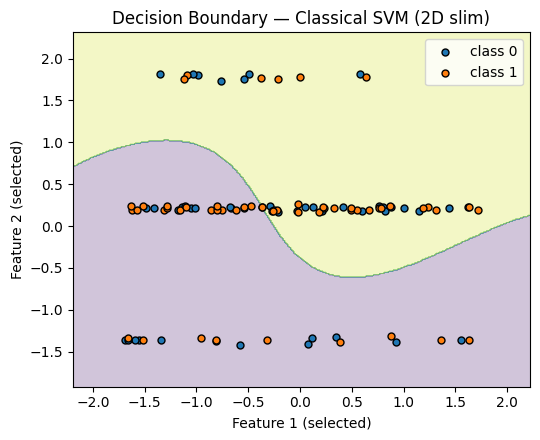

In [22]:
# === Classical SVM baseline on the SAME slim 2D features ===
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Train classical SVM on the exact same inputs used for the quantum kernel
svc_base = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svc_base.fit(X2_train, y_train_small)
y_pred_classical_2d = svc_base.predict(X2_test)

acc_classical_2d = accuracy_score(y_test_small, y_pred_classical_2d)
print("Classical SVM Accuracy (2D slim):", round(acc_classical_2d, 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test_small, y_pred_classical_2d))
print("\nClassification report:\n", classification_report(y_test_small, y_pred_classical_2d, zero_division=0))

# --- Optional: Decision boundary plot (nice for slides) ---
def plot_decision_boundary(clf, X, y, title="Decision Boundary (Classical SVM)"):
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(5.5, 4.5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    # Plot test points
    classes = np.unique(y)
    for c in classes:
        idx = (y_test_small == c)
        plt.scatter(X2_test[idx, 0], X2_test[idx, 1], label=f"class {c}", s=25, edgecolor="k")
    plt.title(title)
    plt.xlabel("Feature 1 (selected)")
    plt.ylabel("Feature 2 (selected)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# Call the plot (comment out if not needed)
plot_decision_boundary(svc_base, X2_test, y_test_small, title="Decision Boundary — Classical SVM (2D slim)")



In [20]:
# Simpler feature map (reps=1 is much faster than 2)
from qiskit.circuit.library import ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=2, reps=1)


In [25]:
from qiskit_machine_learning.kernels import FidelityStatevectorKernel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

sv_kernel = FidelityStatevectorKernel(feature_map=feature_map)

t0 = time.time()
K_train = sv_kernel.evaluate(X2_train)
K_test  = sv_kernel.evaluate(X2_test, X2_train)
print(f"Kernel build time: {time.time()-t0:.2f}s (statevector)")

svc_q = SVC(kernel='precomputed', random_state=42)
svc_q.fit(K_train, y_train_small)
y_pred_q = svc_q.predict(K_test)
acc_quantum = accuracy_score(y_test_small, y_pred_q)
print("Quantum Kernel SVM Accuracy:", round(acc_quantum, 4))

# Comparing the Classical (Slim Version) to the Quantum (Slim Version)
print(f"\nComparison → Classical (2D slim): {acc_classical_2d:.4f} | Quantum (2D slim): {acc_quantum:.4f}")


Kernel build time: 3.54s (statevector)
Quantum Kernel SVM Accuracy: 0.4

Comparison → Classical (2D slim): 0.4900 | Quantum (2D slim): 0.4000


In [19]:
# 10) Classical SVM baseline - Full Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

svc = SVC(kernel='rbf', random_state=42)
svc.fit(X_train_scaled, y_train)
y_pred_classical = svc.predict(X_test_scaled)
acc_classical = accuracy_score(y_test, y_pred_classical)

print("Classical SVM Accuracy:", round(acc_classical, 4))


Classical SVM Accuracy: 0.5065
